## Script to run US-level BLP estimation
Input: Clean BLP data
Output: Demand model coefficients, elasticities, markups, and marginal costs

#### Set up
Imports required libraries, filters data, standardises variables

In [119]:
### Import libraries

import numpy as np
import pandas as pd
import dataclasses
from functools import partial
from typing import Callable
from typing import Tuple
import itertools
import pyblp
import linearmodels

import json
from pathlib import Path

from helpers.ownership import load_owner_map, add_owner_ids, build_owner_ownership
from helpers.counterfactual_helpers import align_product_data_for_sim


In [120]:
# Import data
clean_blp = pd.read_csv('data/raw/blpUS0804.csv')

# Filter out rows we don't want
clean_blp = clean_blp[clean_blp['shares'] > 0.00001]
clean_blp = clean_blp[clean_blp['prices'] < 100000]
clean_blp = clean_blp[~clean_blp['mpg'].isna()]
clean_blp = clean_blp[~clean_blp['weight'].isna()]

# Standardize variables
clean_blp['prices'] = clean_blp['prices'] / 100000
clean_blp['size'] = clean_blp['size'] * 0.006944444 / 100 # Square inches to square feet in 100s
clean_blp['mpg'] = (clean_blp['mpg'] / 10) # mpg in 10s
clean_blp['hp'] = (clean_blp['hp'] / 100) # hp in 100s
clean_blp['weight'] = clean_blp['weight'] / 1000 # weight in 1000s of pounds
clean_blp['hpwt'] = clean_blp['hp'] / clean_blp['weight']

# Construct explicit ev, hybrid dummies
clean_blp['ev'] = (clean_blp['engine_type'] == 'Electric').astype(int)
clean_blp['hybrid'] = (clean_blp['engine_type'] == 'Hybrid').astype(int)

clean_blp = clean_blp[clean_blp['market_ids'] == clean_blp['product_year']]

product_data = clean_blp.copy()


### Post estimation analysis

In [121]:
import pickle

# Load the results object from the file under a new name
import json
from pathlib import Path

cfg_path = Path("results_config.json")
if not cfg_path.exists():
    cfg_path = Path("post_est") / "results_config.json"
cfg = json.loads(cfg_path.read_text())
results_path = Path(cfg["results_file"])
if not results_path.is_absolute():
    results_path = (cfg_path.parent / results_path).resolve()

with open(results_path, "rb") as f:
    results = pickle.load(f)

results

Problem Results Summary:
GMM     Objective      Projected    Reduced Hessian  Reduced Hessian  Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares   Condition Number  Condition Number 
----  -------------  -------------  ---------------  ---------------  -------  ----------------  -----------------
 2    +8.457361E+01  +1.289250E-03   +1.067003E-01    +7.126250E+01      0      +4.516523E+07      +6.250238E+04  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 27:50:17       Yes         109           125         24893        75808   

Nonlinear Coefficient Estimates (Robust SEs Adjusted for 2982 Clusters in Parentheses):
     Sigma:             1        prices - subsidy    ln_mpg_ice     log_size_std     log_hp_std   

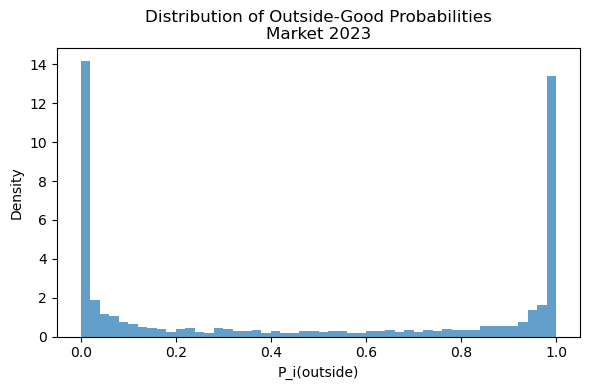

Market 2023:
  mean P(outside)   = 0.488
  median P(outside) = 0.456
  min / max         = 0.000 / 1.000


In [122]:
import numpy as np
import matplotlib.pyplot as plt

def compute_outside_probs_for_market(results, market_id):
    """
    For a given pyblp Results object and a single market_id,
    compute per-agent outside-good probabilities s0_i and inclusive values IV_i.

    Returns:
        IV_i: 1D array of inclusive values for each agent in the market
        s0_i: 1D array of P_i(outside) for each agent in the market
    """
    # ---------------------------------------------------
    # 1. Pull out product and agent data
    # ---------------------------------------------------
    problem = results.problem
    products = problem.products
    agents = problem.agents

    # Market IDs for products and agents
    market_ids_p = np.asarray(products.market_ids)
    market_ids_a = np.asarray(agents.market_ids)

    # Boolean masks for this market
    prod_mask = (market_ids_p == market_id)
    agent_mask = (market_ids_a == market_id)

    if not prod_mask.any():
        raise ValueError(f"No products found for market_id={market_id}")
    if not agent_mask.any():
        raise ValueError(f"No agents found for market_id={market_id}")

    # ---------------------------------------------------
    # 2. Extract the relevant slices
    # ---------------------------------------------------
    # Mean utilities (delta) in same order as products
    delta_full = np.asarray(results.delta)              # shape (J_total,)
    delta_t = delta_full[prod_mask]                     # shape (J_t,)

    # X2: characteristics with random coefficients (price, mpg, hp, size, EV, SUV, intercept, etc.)
    X2_full = np.asarray(products.X2)                   # shape (J_total, K)
    X2_t = X2_full[prod_mask.reshape(-1), :]                        # shape (J_t, K)

    # Agent-side random draws and demographics
    nodes_full = np.asarray(agents.nodes)               # shape (I_total, K)
    dem_full = np.asarray(agents.demographics)          # shape (I_total, D)

    nodes_t = nodes_full[agent_mask.reshape(-1), :]                 # shape (I_t, K)
    dem_t = dem_full[agent_mask.reshape(-1), :]                     # shape (I_t, D)

    # Model parameters
    beta = np.asarray(results.beta)                     # shape (K,) for X2 if used as X1 too
    Sigma = np.asarray(results.sigma)                   # shape (K, K), Cholesky factor
    Pi = np.asarray(results.pi)                         # shape (K, D)

    # ---------------------------------------------------
    # 3. Compute taste shocks for each agent
    #    taste_shocks_i = Sigma v_i + Pi d_i
    # ---------------------------------------------------
    # nodes_t: (I_t, K); Sigma: (K, K) --> (I_t, K)
    shocks_from_nodes = nodes_t @ Sigma.T               # Σ v_i
    # dem_t: (I_t, D); Pi: (K, D) --> (I_t, K)
    shocks_from_dem = dem_t @ Pi.T                      # Π d_i

    # Total deviation from mean tastes: shape (I_t, K)
    taste_shocks_t = shocks_from_nodes + shocks_from_dem

    # ---------------------------------------------------
    # 4. Compute μ_ijt = X2_j · taste_shocks_i and V_ijt = δ_j + μ_ijt
    # ---------------------------------------------------
    # X2_t: (J_t, K), taste_shocks_t.T: (K, I_t) --> μ_ijt: (J_t, I_t)
    mu_ijt = X2_t @ taste_shocks_t.T

    # delta_t: (J_t,) --> broadcast to (J_t, I_t)
    V_ijt = delta_t[:, None] + mu_ijt

    # ---------------------------------------------------
    # 5. Compute inclusive value IV_i and outside probability s0_i
    #    IV_i = log sum_j exp(V_ijt)
    # ---------------------------------------------------
    # Numeric stability: subtract max across j
    max_V = np.max(V_ijt, axis=0)              # shape (I_t,)
    exp_V_shifted = np.exp(V_ijt - max_V)      # shape (J_t, I_t)
    sum_exp_V = np.sum(exp_V_shifted, axis=0)  # shape (I_t,)

    IV_i = max_V + np.log(sum_exp_V)           # shape (I_t,)

    # Outside-good probability for each agent:
    # s0_i = 1 / (1 + exp(IV_i))
    s0_i = 1.0 / (1.0 + np.exp(IV_i))

    return IV_i, s0_i


def plot_outside_prob_distribution(results, market_id, bins=50):
    """
    Convenience wrapper: compute outside probabilities for a market
    and plot their distribution.
    """
    IV_i, s0_i = compute_outside_probs_for_market(results, market_id)

    plt.figure(figsize=(6,4))
    plt.hist(s0_i, bins=bins, density=True, alpha=0.7)
    plt.xlabel("P_i(outside)")
    plt.ylabel("Density")
    plt.title(f"Distribution of Outside-Good Probabilities\nMarket {market_id}")
    plt.tight_layout()
    plt.show()

    print(f"Market {market_id}:")
    print(f"  mean P(outside)   = {s0_i.mean():.3f}")
    print(f"  median P(outside) = {np.median(s0_i):.3f}")
    print(f"  min / max         = {s0_i.min():.3f} / {s0_i.max():.3f}")


# ---------------------------------------------------
# Example usage
# ---------------------------------------------------

# Suppose you already have `results` from pyblp. Choose a market id:
# For example, your markets might be years (2018, 2019, ...) or state-year pairs.
# Replace this with a real market_id from products.market_ids:
market_example = 2023

# Then:
plot_outside_prob_distribution(results, market_example)


In [123]:
import numpy as np

def compute_second_choice_outside_share(results, market_id):
    """
    For a given pyblp Results object and market_id, compute the fraction of agents
    whose *first* choice is an inside good (j >= 1) and *second* choice is the outside good (j = 0),
    based on deterministic utilities V_ijt = delta_jt + mu_ijt.

    Returns:
        share_second_outside: float in [0,1]
        first_choice: array of first-choice indices (0 = outside, 1..J_t = inside products)
        second_choice: array of second-choice indices (same coding)
    """

    problem = results.problem
    products = problem.products
    agents = problem.agents

    # --- 1. Masks for this market ---
    market_ids_p = np.asarray(products.market_ids)
    market_ids_a = np.asarray(agents.market_ids)

    prod_mask = (market_ids_p == market_id)
    agent_mask = (market_ids_a == market_id)

    if not prod_mask.any():
        raise ValueError(f"No products found for market_id={market_id}")
    if not agent_mask.any():
        raise ValueError(f"No agents found for market_id={market_id}")

    # --- 2. Slice product- and agent-side arrays ---
    # Mean utilities (delta)
    delta_full = np.asarray(results.delta)        # (J_total,)
    delta_t = delta_full[prod_mask]               # (J_t,)

    # X2: characteristics with random coefficients
    X2_full = np.asarray(products.X2)             # (J_total, K)
    X2_t = X2_full[prod_mask.reshape(-1), :]                  # (J_t, K)

    # Agent-side draws and demographics
    nodes_full = np.asarray(agents.nodes)         # (I_total, K)
    dem_full = np.asarray(agents.demographics)    # (I_total, D)

    nodes_t = nodes_full[agent_mask.reshape(-1), :]           # (I_t, K)
    dem_t = dem_full[agent_mask.reshape(-1), :]               # (I_t, D)

    # Parameters
    beta = np.asarray(results.beta)               # mean tastes (K,)
    Sigma = np.asarray(results.sigma)             # (K, K), Cholesky factor
    Pi = np.asarray(results.pi)                   # (K, D)

    # --- 3. Taste shocks for each agent: Σ v_i + Π d_i ---
    shocks_nodes = nodes_t @ Sigma.T             # (I_t, K)
    shocks_dem = dem_t @ Pi.T                    # (I_t, K)
    taste_shocks_t = shocks_nodes + shocks_dem   # (I_t, K)

    # --- 4. Compute μ_ijt and V_ijt for inside goods ---
    # μ_ijt = X2_j · taste_shocks_i
    mu_ijt = X2_t @ taste_shocks_t.T             # (J_t, I_t)

    # Add delta: broadcast to (J_t, I_t)
    V_inside = delta_t[:, None] + mu_ijt         # (J_t, I_t)

    # --- 5. Add the outside good (j=0) with V_i0 = 0 ---
    I_t = V_inside.shape[1]
    V_outside = np.zeros((1, I_t))               # (1, I_t)
    # Stack so that row 0 = outside, rows 1..J_t = inside products
    V_all = np.vstack([V_outside, V_inside])     # (1 + J_t, I_t)

    # --- 6. Find first and second best alternatives for each agent ---
    # argsort ascending, then take last two rows
    order = np.argsort(V_all, axis=0)            # (1+J_t, I_t)
    first_choice = order[-1, :]                  # (I_t,)
    second_choice = order[-2, :]                 # (I_t,)

    # --- 7. Compute share with first inside, second outside ---
    mask_first_inside = (first_choice != 0)          # exclude those whose best option is already outside
    mask_second_outside = (second_choice == 0)
    both = mask_first_inside & mask_second_outside

    print(f"Ratio of second-outside to first-inside among those with first inside: {both.sum() / mask_first_inside.sum():.3f}")
    share_second_outside = both.mean()

    return share_second_outside, first_choice, second_choice


# Convenience wrapper to print the result
def report_second_choice_outside(results, market_id):
    share, first_choice, second_choice = compute_second_choice_outside_share(results, market_id)
    print(f"Market {market_id}:")
    print(f"  Share of agents with first choice = inside, second choice = outside: {share:.3f}")
    return share, first_choice, second_choice

# Example usage:
market_example = 2024
share, first_choice, second_choice = compute_second_choice_outside_share(results, market_example)



Ratio of second-outside to first-inside among those with first inside: 0.069


In [124]:
import numpy as np
pyblp.options.verbose = False
# === Own-price elasticities (share-weighted) ===
elasticities = results.compute_elasticities()
elasticities_diag = results.extract_diagonals(elasticities)  # 1D: product–market order
# Get products object (works across pyblp versions)
products_obj = getattr(results, "products", None)
if products_obj is None:
    products_obj = results.problem.products
shares = np.asarray(products_obj.shares, dtype=float)
prices = np.asarray(products_obj.prices, dtype = float)
mask = np.isfinite(elasticities_diag) & np.isfinite(shares) & (shares > 0)
mean_elasticity_w = np.average(elasticities_diag[mask], weights=shares[mask])
print(f"\nShare-weighted mean own-price elasticity: {mean_elasticity_w:.6f}")
# Weighted fraction above -1
above_minus_one = (elasticities_diag > -1).astype(float)
pct_above_minus_one_w = 100 * np.average(above_minus_one[mask], weights=shares[mask])
print(f"Share-weighted % of elasticities > -1: {pct_above_minus_one_w:.2f}%")
# === Costs and markups (share-weighted) ===
cfg_path = Path("results_config.json") if Path("results_config.json").exists() else Path("post_est") / "results_config.json"
cfg = json.loads(cfg_path.read_text())
ownership_mode = cfg.get("ownership_mode", "firm")
owner_mapping_path = cfg.get("owner_mapping_path")
allow_unmapped_brands = bool(cfg.get("allow_unmapped_brands", False))
owner_map = None
ownership = None
if ownership_mode == "owner":
    if not owner_mapping_path:
        raise ValueError("ownership_mode=owner requires owner_mapping_path in results_config.json")
    owner_map_path = Path(owner_mapping_path)
    if not owner_map_path.is_absolute():
        owner_map_path = (cfg_path.parent / owner_map_path).resolve()
    owner_map = load_owner_map(owner_map_path)
    product_data = add_owner_ids(product_data, owner_map, firm_col="firm_ids", owner_col="owner_ids", allow_unmapped=allow_unmapped_brands)
    aligned_pd = align_product_data_for_sim(results, product_data, id_col="product_ids", market_col="market_ids")
    ownership = build_owner_ownership(aligned_pd, owner_col="owner_ids", market_col="market_ids")
    costs = results.compute_costs(ownership=ownership)
    markups = results.compute_markups(costs=costs)
else:
    costs = results.compute_costs()
    markups = results.compute_markups(costs=costs)
markups = np.asarray(markups, dtype=float)
mask_m = np.isfinite(markups) & np.isfinite(shares) & (shares > 0)
avg_markup_w = np.average(markups[mask_m], weights=shares[mask_m])
print(f"\nShare-weighted average markup: {avg_markup_w:.6f}")
# Calculate aggregate elasticities
agg_elas = results.compute_aggregate_elasticities().mean()
print(f"Market elasticity: {agg_elas}")


Share-weighted mean own-price elasticity: -6.764015
Share-weighted % of elasticities > -1: 0.00%

Share-weighted average markup: 0.172033
Market elasticity: -0.4196813727910699


### Elasticities and Markups (2024)

Distribution plots for own-price elasticities and markups in 2024, plus average markup by year.


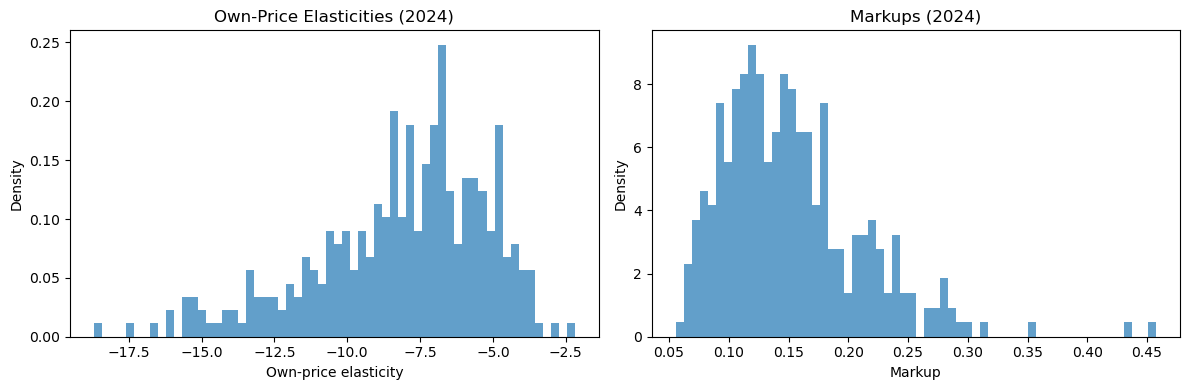

/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_72662/2335130027.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g["markup"], weights=g["share"]))


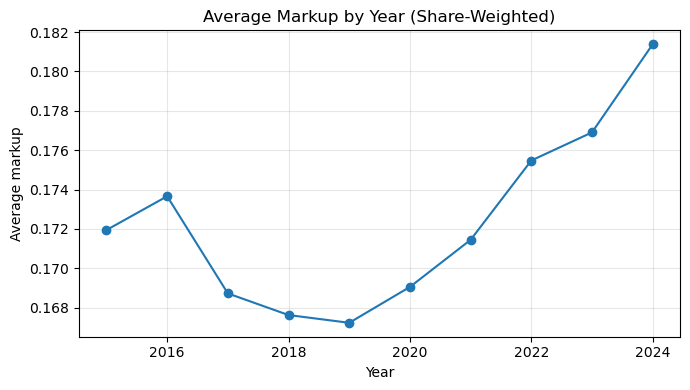

In [116]:
# --- Distributions for 2024 ---
products_obj = getattr(results, "products", None) or results.problem.products
market_ids = np.asarray(products_obj.market_ids).reshape(-1)
years = pd.to_numeric(market_ids, errors="coerce").reshape(-1)
shares = np.asarray(products_obj.shares, dtype=float).reshape(-1)

mask_2024 = years == 2024

elas_2024 = elasticities_diag[mask_2024]
elas_2024 = elas_2024[np.isfinite(elas_2024)]

markups = np.asarray(markups, dtype=float).reshape(-1)

mk_2024 = markups[mask_2024]
mk_2024 = mk_2024[np.isfinite(mk_2024)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(elas_2024, bins=60, density=True, alpha=0.7)
axes[0].set_title("Own-Price Elasticities (2024)")
axes[0].set_xlabel("Own-price elasticity")
axes[0].set_ylabel("Density")

axes[1].hist(mk_2024, bins=60, density=True, alpha=0.7)
axes[1].set_title("Markups (2024)")
axes[1].set_xlabel("Markup")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# --- Average markup by year (share-weighted) ---
df = pd.DataFrame({
    "year": years,
    "markup": markups,
    "share": shares,
})
df = df[np.isfinite(df["year"]) & np.isfinite(df["markup"]) & np.isfinite(df["share"]) & (df["share"] > 0)]

avg_markup = (
    df.groupby("year")
      .apply(lambda g: np.average(g["markup"], weights=g["share"]))
      .reset_index(name="avg_markup")
)

plt.figure(figsize=(7, 4))
plt.plot(avg_markup["year"], avg_markup["avg_markup"], marker="o")
plt.title("Average Markup by Year (Share-Weighted)")
plt.xlabel("Year")
plt.ylabel("Average markup")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [117]:
# Align product_data to results order before attaching costs/markups
product_data = align_product_data_for_sim(results, product_data, id_col="product_ids", market_col="market_ids")
product_data["costs"] = costs
product_data["markups"] = markups

costs_df = product_data[["product_ids","market_year", "costs", "markups"]]

In [118]:
# === Save vehicle-level costs/markups with price and characteristics ===
vehicle_cols = [
    "product_ids", "market_ids", "market_year", "firm_ids", "owner_ids",
    "prices", "costs", "markups",
    "shares", "sales", "size", "weight", "engine_size", "hp", "hpwt", "mpg",
    "vehicle_type", "body_type", "engine_type", "drive_type", "ev", "hybrid",
    "distw", "home_mkt", "ppp", "ppp_lag1", "rer", "rer_lag1", "xrx", "xrx_lag1",
    "product_year", "old_model", "next_model", "plant_country", "plant_location"
]

vehicle_data = product_data.loc[:, vehicle_cols].copy()
vehicle_data_file = "data/derived/vehicle_costs_markups_chars.csv"
vehicle_data.to_csv(vehicle_data_file, index=False)
print(f"Saved vehicle data with costs/markups to {vehicle_data_file} (rows={len(vehicle_data)}, cols={len(vehicle_cols)})")

Saved vehicle data with costs/markups to data/derived/vehicle_costs_markups_chars.csv (rows=2982, cols=34)


### Check divergence ratios

In [53]:
labels = results.problem.products.clustering_ids.reshape(-1)

# Filter labels to those starting with '2024'
labels = labels[np.array(results.problem.products.market_ids == 2024).reshape(-1)]

diversions = results.compute_diversion_ratios(market_id=2024)

diversion_diags = results.extract_diagonals(diversions, market_id=2024).reshape(-1)

labels = results.problem.products.clustering_ids.reshape(-1)

# Filter labels to those starting with '2024'
labels = labels[np.array(results.problem.products.market_ids == 2024).reshape(-1)]

# Create dataframe of labels and diversion_diags
diversion_df = pd.DataFrame({'product_ids': labels, 'diversion_ratio': diversion_diags})
diversion_df

# Create square dataframe of diversion ratios for market 2024, using labels for the row and column indices
diversion_matrix = pd.DataFrame(diversions, index=labels, columns=labels)
diversion_matrix

# Print mean diagonal
mean_diag = np.mean(np.diag(diversion_matrix))
print(f"Mean diagonal of diversion matrix for market 2024: {mean_diag:.6f}")

Mean diagonal of diversion matrix for market 2024: 0.138985


In [132]:
# Filter diversion_matrix to a given product_id, show top 5 diversions to other products
product_id = '2024_tesla_model3ev'  # Replace with desired product_id
top_diversions = diversion_matrix.loc[product_id].sort_values(ascending=False).head(6)  # Including self-diversion
top_diversions

2024_tesla_model3ev       0.392767
2024_tesla_modelyev       0.145000
2024_bmw_i4ev             0.027334
2024_tesla_modelsev       0.021071
2024_hyundai_ioniq5ev     0.015350
2024_lucidmotors_airev    0.012533
Name: 2024_tesla_model3ev, dtype: float64

In [ ]:
# Build LaTeX-ready table: vertical diversions per product (outside good + top 5)
vehicle_ids = [
    '2024_tesla_model3ev',
    '2024_toyota_rav4hybrid',
    '2024_ford_bronco',
    '2024_audi_a5',
    '2024_honda_civic',
    '2024_ford_f150',
]

# Ensure diversion_matrix exists for 2024
if 'diversion_matrix' not in globals():
    labels = results.problem.products.clustering_ids.reshape(-1)
    labels = labels[(results.problem.products.market_ids == 2024).reshape(-1)]
    diversions = results.compute_diversion_ratios(market_id=2024)
    diversion_matrix = pd.DataFrame(diversions, index=labels, columns=labels)

def build_diversion_table(product_id, top_n=5):
    row = diversion_matrix.loc[product_id].copy()
    outside_good = row[product_id]
    row_no_self = row.drop(index=product_id)
    top = row_no_self.sort_values(ascending=False).head(top_n)

    entries = [('outside_good', outside_good)] + list(top.items())
    df = pd.DataFrame(entries, columns=['alternative', 'share'])
    df['share'] = (df['share'] * 100).map(lambda x: f"{x:.1f}%")
    return df

def build_panel_table(product_ids):
    panel_frames = []
    for vid in product_ids:
        df = build_diversion_table(vid, top_n=5)
        df.columns = pd.MultiIndex.from_product([[vid], df.columns])
        panel_frames.append(df)
    return pd.concat(panel_frames, axis=1)

def panel_column_format(panel_count, alt_width=0.19):
    # Fixed-width alternative columns keep panel widths aligned.
    cols = ["@{}"]
    for _ in range(panel_count):
        cols.append(f"p{{{alt_width:.2f}\\textwidth}}")
        cols.append("r@{}")
    return "".join(cols)

# Split into two rows of panels to avoid tiny text
rows_of_panels = [vehicle_ids[:3], vehicle_ids[3:]]
latex_blocks = []
for row_ids in rows_of_panels:
    panel_table = build_panel_table(row_ids)
    col_format = panel_column_format(len(row_ids))
    latex_blocks.append(
        panel_table.to_latex(
            index=False,
            escape=True,
            multicolumn=True,
            multicolumn_format='c',
            column_format=col_format,
        )
    )

latex_table = rf"""\begin{{table}}[!htbp]
\centering
\small
\setlength{{\tabcolsep}}{{3pt}}
\renewcommand{{\arraystretch}}{{1.1}}
{latex_blocks[0]}
\vspace{{0.6em}}
{latex_blocks[1]}
\caption{{Outside-good diversion and top five diversion destinations (2024)}}
\label{{tab:diversions_top5}}
\end{{table}}
"""

print(latex_table)


In [62]:
# Check characteristics of 2024_chevrolet_tahoe, 2024_ford_bronco, 2024_toyota_4runner in clean_blp
clean_blp[(clean_blp['product_ids'] == '2024_ford_bronco') | 
          (clean_blp['product_ids'] == '2024_jeep_grandcherokee') | 
          (clean_blp['product_ids'] == '2024_chevrolet_tahoe')|
          (clean_blp['product_ids'] == '2024_toyota_rav4hybrid')][['product_ids', 'prices', 'size', 'mpg', 'hp', 'hpwt', 'ev', 'hybrid', 'vehicle_type']]

,product_ids,prices,size,mpg,hp,hpwt,ev,hybrid,vehicle_type
10052,2024_chevrolet_tahoe,0.485786,1.185187,1.7,3.55,0.627874,0,0,SUV
10075,2024_ford_bronco,0.373783,1.133769,1.7,3.15,0.686723,0,0,SUV
10149,2024_jeep_grandcherokee,0.337255,1.136812,2.2,2.93,0.671249,0,0,SUV
10324,2024_toyota_rav4hybrid,0.260043,0.917062,3.9,2.19,0.580132,0,1,SUV
